# STEM simulations

In [1]:
from ase.build import mx2
import matplotlib.pyplot as plt
import numpy as np

from abtem.plot import plot_atoms, plot_ctf, domain_coloring
from abtem.transform import orthogonalize_atoms
from abtem.waves import ProbeWaves
from abtem.detect import RingDetector, FourierSpaceDetector
from abtem.potentials import Potential
from abtem.analyse import fwhm, center_of_mass
from abtem.noise import add_scan_noise, add_poisson_noise

In this lesson, you will learn how to simulate a STEM image of MoS2. If you wish, you can chose another structure based on what you learned in lesson 1.

## Creating MoS2
ASE has a module for creating MX2 2D structures such as MoS2. As described in lesson 1, we orthogonalize the structure and repeat it to accomodate the size of the electron probe. For illustrative purposes we add a scan area over an orthognal unit cell to the plot of the atoms.

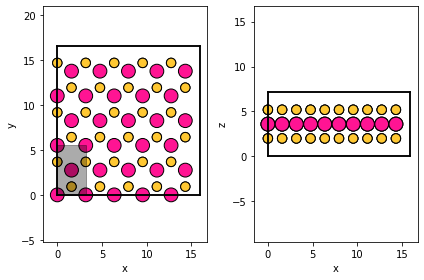

In [2]:
from ase.lattice.hexagonal import Graphite

atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19)
atoms.center(vacuum=2, axis=2) # reduce amount of vacuum
atoms = orthogonalize_atoms(atoms)

unit_cell = atoms.cell.copy()

atoms *= (5, 3, 1)

scan_area = [(0, 0), np.diag(unit_cell)[:2]]

fig,(ax1,ax2)=plt.subplots(1,2)
plot_atoms(atoms, ax=ax1, scan_area=scan_area)
plot_atoms(atoms, ax=ax2, plane='xz')
plt.tight_layout()

An easy way to speed up a STEM image simulation is to precalculate the potential, this means that it does not have to be recalculated for each probe position. The only consideration is whether the entire potential can fit into memory.

In [3]:
potential = Potential(atoms, sampling=.05).precalculate()

## The electron probe
The order of the optical components of the STEM is reversed from that of the HRTEM. The objective lens is before the specimen and forms a focused probe on the specimen. Nonetheless, some of the theory is the same, in fact the `ProbeWaves` object is a descendent of the `CTFBase`, which also defined most of the functionality of the `CTF` object.

1.2000000000000002


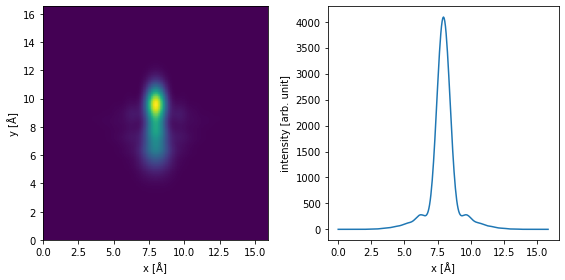

In [18]:
probe = ProbeWaves(sampling=.05, 
                   cutoff=.032, 
                   rolloff=.1, 
                   focal_spread=50,
                   energy=60e3, 
                   Cs=-15e4,
                   extent=np.diag(atoms.cell)[:2],
                   defocus=10) 

probe.set_parameters({'C10':100, 'C12':100, 'C23':1e3})


image = probe.get_image()
profile = image.get_profile()

print(fwhm(profile))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image.array.T, extent=[0,image.extent[0],0,image.extent[1]])
ax1.set_xlabel('x [Å]')
ax1.set_ylabel('y [Å]')
ax2.plot(profile.linspace()[0], profile.array)
ax2.set_xlabel('x [Å]')
ax2.set_ylabel('intensity [arb. unit]')
plt.tight_layout()

The `ProbeWaves` object is a descendent of the `CTFBase`, hence we can also use the `plot_ctf` on `ProbeWaves`.

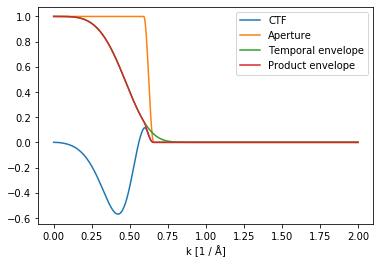

In [5]:
plot_ctf(probe, 2)

## Detectors
The `RingDetector` object can be used for simulating the standard modes of STEM, i.e. bright field, MAADF and HAADF measurements. The only difference between these are the inner and outer radial integration limits, below we create a detector representing each mode and plot the respective detector efficiency.

The `FourierSpaceDetector` can used for doing 4D STEM. Using this detector it is possible to define any integration, hence the only downside to using this is that a full 4D dataset can take up a lot of memory. The `FourierSpaceDetector`object can also be used for simulating Ptychography datasets.

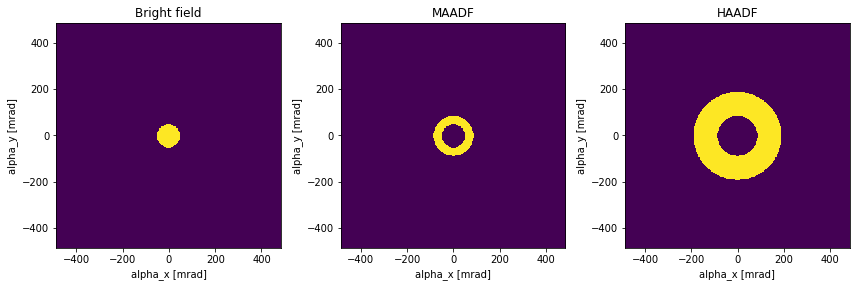

In [6]:
bright = RingDetector(inner=.0, outer=.05, extent=probe.extent, gpts=probe.gpts, energy=probe.energy)
maadf = RingDetector(inner=.05, outer=.086, extent=probe.extent, gpts=probe.gpts, energy=probe.energy)
haadf = RingDetector(inner=.086, outer=.19, extent=probe.extent, gpts=probe.gpts, energy=probe.energy)
full_field = FourierSpaceDetector()



bright_efficiency = bright.get_efficiency()
maadf_efficiency = maadf.get_efficiency()
haadf_efficiency = haadf.get_efficiency()

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.imshow(np.fft.fftshift(bright_efficiency.array), extent=bright_efficiency.fourier_limits.ravel() * 
           bright_efficiency.wavelength * 1e3)
ax1.set_title('Bright field')

ax2.imshow(np.fft.fftshift(maadf_efficiency.array), extent=maadf_efficiency.fourier_limits.ravel() * 
           maadf_efficiency.wavelength * 1e3)
ax2.set_title('MAADF')

ax3.imshow(np.fft.fftshift(haadf_efficiency.array), extent=haadf_efficiency.fourier_limits.ravel() * 
           haadf_efficiency.wavelength * 1e3)
ax3.set_title('HAADF')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('alpha_x [mrad]')
    ax.set_ylabel('alpha_y [mrad]')

plt.tight_layout()

## Scanning
In STEM the image is built up by scanning the focused probe over the specimen and recording the transmitted intensity at each position of the probe. Simulating a large image can be expensive since each pixel requires a full multislice calculation. 

It is possible to achieve a decent speedup by using batching. This trades memory for speed by propagating a batch of probes at the same time, allowing more efficient use of threads. The maximum batch size can be specified with the `max_batch` argument.

In [7]:
detectors = [bright, maadf, haadf, full_field]

linescan = probe.line_scan(potential, 
                           detectors=detectors,
                           start=[atoms[0].position[0], 0], 
                           end=[atoms[0].position[0], unit_cell[1,1]], 
                           sampling=.1, 
                           max_batch=200)

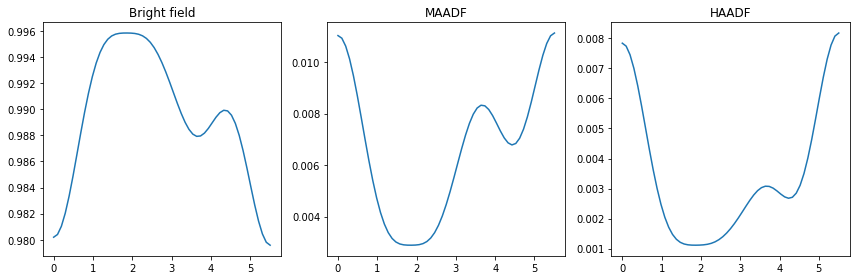

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.plot(linescan.get_positions()[:,1], linescan.measurements[bright])
ax1.set_title('Bright field')

ax2.plot(linescan.get_positions()[:,1], linescan.measurements[maadf])
ax2.set_title('MAADF')

ax3.plot(linescan.get_positions()[:,1], linescan.measurements[haadf])
ax3.set_title('HAADF')

plt.tight_layout()

In [9]:
gridscan = probe.grid_scan(potential,
                           detectors=detectors, 
                           start=[0,0], 
                           end=scan_area[1], 
                           sampling=.2, 
                           max_batch=200)

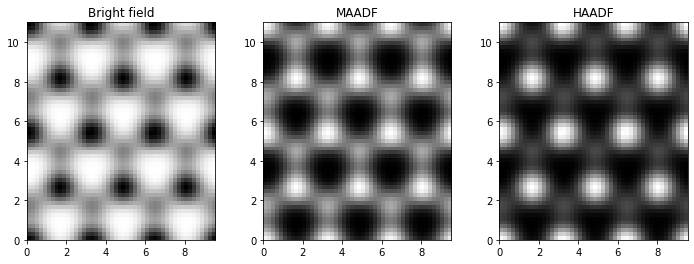

In [10]:
bright_image = gridscan.get_image(bright)
maadf_image = gridscan.get_image(maadf)
haadf_image = gridscan.get_image(haadf)

bright_image = bright_image.repeat((3,2))
maadf_image = maadf_image.repeat((3,2))
haadf_image = haadf_image.repeat((3,2))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.imshow(bright_image.array.T, extent=[0, bright_image.extent[0], 0, bright_image.extent[1]], cmap='gray')
ax1.set_title('Bright field')

ax2.imshow(maadf_image.array.T, extent=[0, maadf_image.extent[0], 0, maadf_image.extent[1]], cmap='gray')
ax2.set_title('MAADF')

ax3.imshow(haadf_image.array.T, extent=[0, haadf_image.extent[0], 0, haadf_image.extent[1]], cmap='gray')
ax3.set_title('HAADF');

The last "scan" we will look at is the `CustomScan` object. With this scan it is possible to define a few specific probe positions, this might be useful for determining the intensity ratio between two atomic columns.

In [11]:
atom1 = atoms[0]
atom2 = atoms[1]

print(atom1, '\n', atom2)

custom_scan = probe.custom_scan(potential, detectors=detectors, 
                  positions=[atom1.position[:2], atom2.position[:2]], show_progress=False)

Atom('Mo', [0.0, 0.0, 3.5949999999999998], index=0) 
 Atom('S', [1.59, 0.9179869280115049, 5.1899999999999995], index=1)


Calculating the ratio between the intensity of the Mo column and the S2 column, we see that the bright field contrast is quite low and the HAADF contrast is larger than MAADF contrast.

In [12]:
bright_ratio = custom_scan.measurements[bright][0] / custom_scan.measurements[bright][1]

maadf_ratio = custom_scan.measurements[maadf][0] / custom_scan.measurements[maadf][1]

haadf_ratio = custom_scan.measurements[haadf][0] / custom_scan.measurements[haadf][1]

print('Bright field ratio: \t', bright_ratio)
print('MAADF ratio: \t\t', maadf_ratio)
print('HAADF ratio: \t\t', haadf_ratio)

Bright field ratio: 	 0.9920922463731819
MAADF ratio: 		 1.327209190178787
HAADF ratio: 		 2.5690321932072706


## Scan noise
As for HRTEM images, adding noise may be useful for method development. abTEM's model of scan noise is created by Lewys Jones, see .

In [13]:
flyback_time = 361e-6  # Flyback time [s]
dwell_time = 8e-6      # Dwell time [s]
max_frequency = 50     # [Hz]
target_RMS_power = 70  # In percentage of magnification deviation

In [14]:
scan_noisy_image = add_scan_noise(haadf_image, flyback_time, dwell_time, max_frequency, target_RMS_power)
noisy_image = add_poisson_noise(scan_noisy_image, background=1, dose=1e3)

print('actual dose: {:.2f} e-/Å^2'.format(np.mean(noisy_image.array) / np.prod(noisy_image.sampling)))

actual dose: 999.51 e-/Å^2


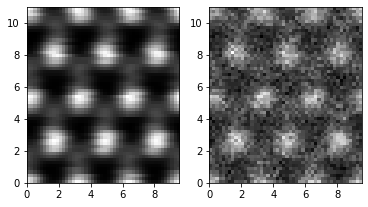

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(scan_noisy_image.array.T, extent=[0, noisy_image.extent[0], 0, noisy_image.extent[1]], cmap='gray')
ax2.imshow(noisy_image.array.T, extent=[0, noisy_image.extent[0], 0, noisy_image.extent[1]], cmap='gray')